# 합성곱 신경망의 시각화

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/8-3.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [2]:
# 경고메세지 안뜨게끔,,
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## 가중치 시각화

In [4]:
from tensorflow import keras

In [6]:
model = keras.models.load_model('best-cnn-model.h5')  # 체크포인트 파일 불러오기

In [7]:
model.layers

#### weights의 첫번째 원소는 층의 가중치 , weights의 두번째 원소는 층의 절편 

In [9]:
conv = model.layers[0]

print(conv.weights[0].shape, conv.weights[1].shape)  # 가중치, 절편의 크기

(3, 3, 1, 32) (32,)


In [10]:
conv_weights = conv.weights[0].numpy()  # 넘파이 배열로 변환

print(conv_weights.mean(), conv_weights.std())  # 평균과 표준편차 계산

-0.018945258 0.24118595


In [11]:
import matplotlib.pyplot as plt

#### 히스토그램을 그리기 위해 1차원 배열로 변환해야함. reshape=(-1,1)로 한개의 열로 바꿈

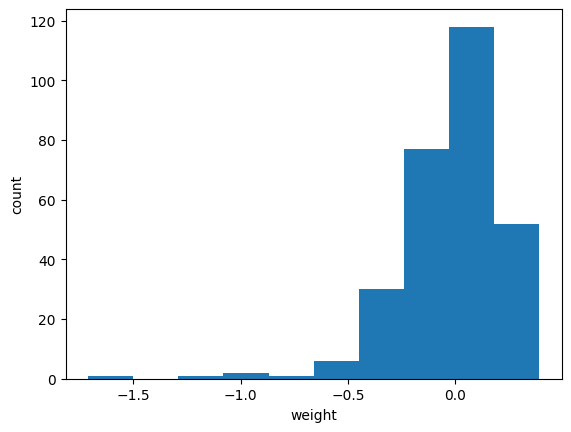

In [12]:
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

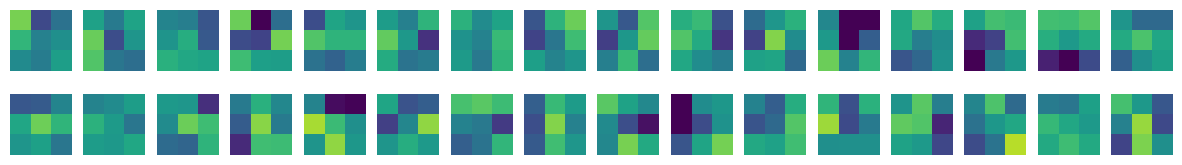

In [13]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):  # 32개 커널 출력
    for j in range(16):
        axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)  # [:,:,0,0]에서 [:,:,0,31]까지
        axs[i, j].axis('off')

plt.show()

In [14]:
no_training_model = keras.Sequential()

no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', 
                                          padding='same', input_shape=(28,28,1)))

In [15]:
no_training_conv = no_training_model.layers[0]  # 가중치를 no_training_conv 변수에 저장

print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [16]:
no_training_weights = no_training_conv.weights[0].numpy()  # 넘파이로 변환

print(no_training_weights.mean(), no_training_weights.std())  # 평균과 표준편차 계산

-0.0016975602 0.08003447


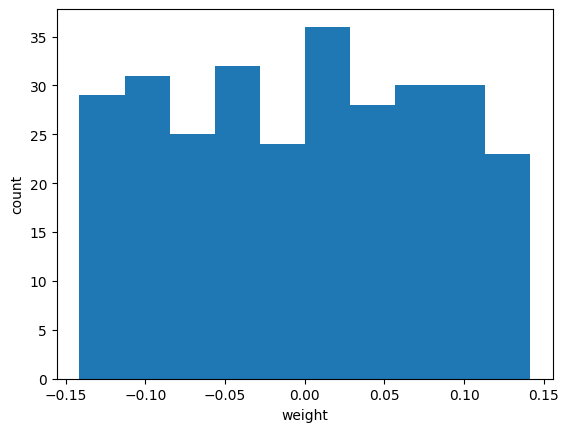

In [17]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

가중치가 비교적 고른 분포. 텐서플로가 신경망의 가중치를 처음 초기화할때 `균등 분포에서 랜덤하게 값`을 선택하기 때문!

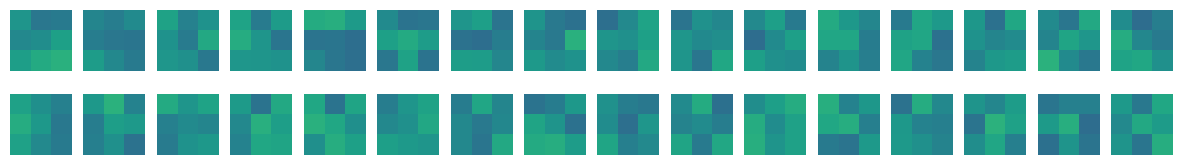

In [18]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

전체적으로 밋밋한 가중치

## 함수형 API

In [19]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


#### model.input과 model.layers[0].output을 연결하는 conv_acti 모델 만들기

In [21]:
conv_acti = keras.Model(model.input, model.layers[0].output)  # 모델 객체의 입력, Conv2D층이 출력한 특성맵(output 속성)

## 특성 맵 시각화

In [22]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

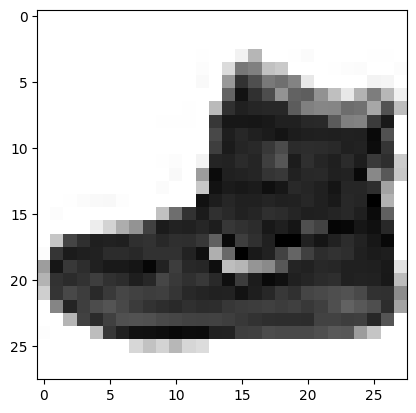

In [23]:
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

#### 케라스 fit(), predict(), evaluate() 메소드는 입력의 첫번째 차원이 배치 차원일 것으로 기대함
- 하나의 샘플을 전달하더라도 꼭 `첫번째 차원을 유지`해아한다 !!
- (784,) 크기를 (28,28,1) 크기로 변경한다

In [24]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1)/255.0  

feature_maps = conv_acti.predict(inputs)

1/1 [==============================] - 0s 62ms/step


In [25]:
print(feature_maps.shape)

(1, 28, 28, 32)


첫번째 차원은 배치 차원, 세임 패딩과 32개의 필터를 사용한 합성곱 층 출력이기 때문에 32

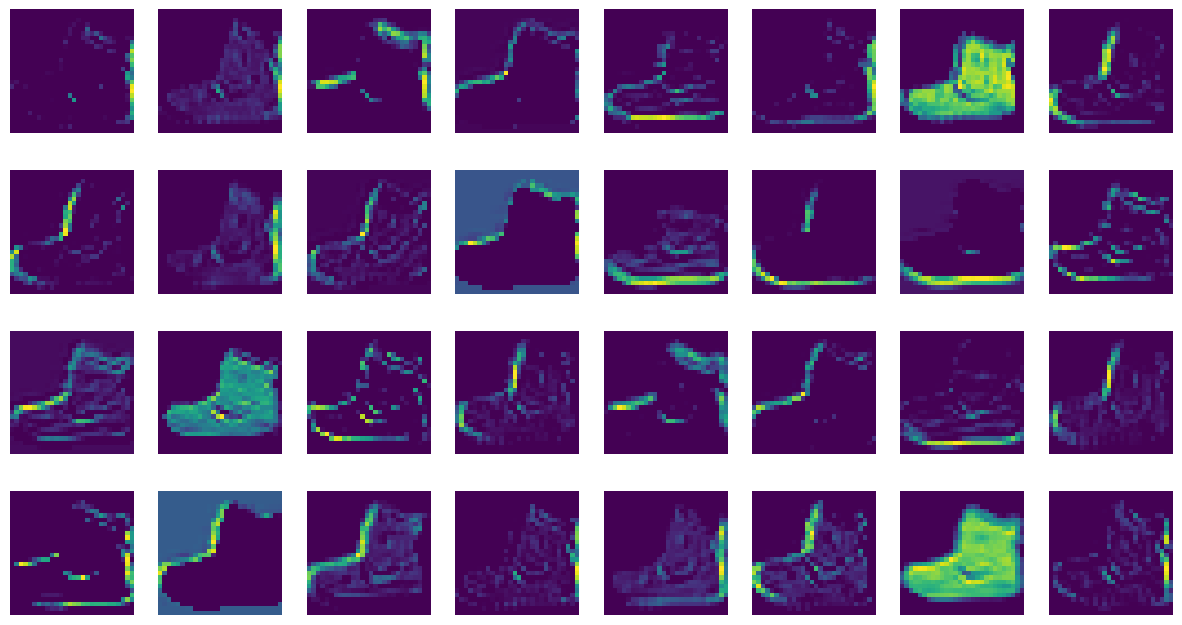

In [26]:
# 특성맵 그리기

fig, axs = plt.subplots(4, 8, figsize=(15,8))

for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')

plt.show()

32개 필터의 가중치를 출력한 그림이 밝은 것이 해당 이미지를 잘 감지했다

#### 두번째 합성곱 층이 만든 특성맵 확인

In [27]:
conv2_acti = keras.Model(model.input, model.layers[2].output)

In [28]:
feature_maps = conv2_acti.predict(train_input[0:1].reshape(-1, 28, 28, 1)/255.0)

1/1 [==============================] - 0s 39ms/step


In [29]:
print(feature_maps.shape)

(1, 14, 14, 64)


첫번째 차원은 배치 차원, 64개의 필터를 사용한 합성곱 층 출력이기 때문에 64

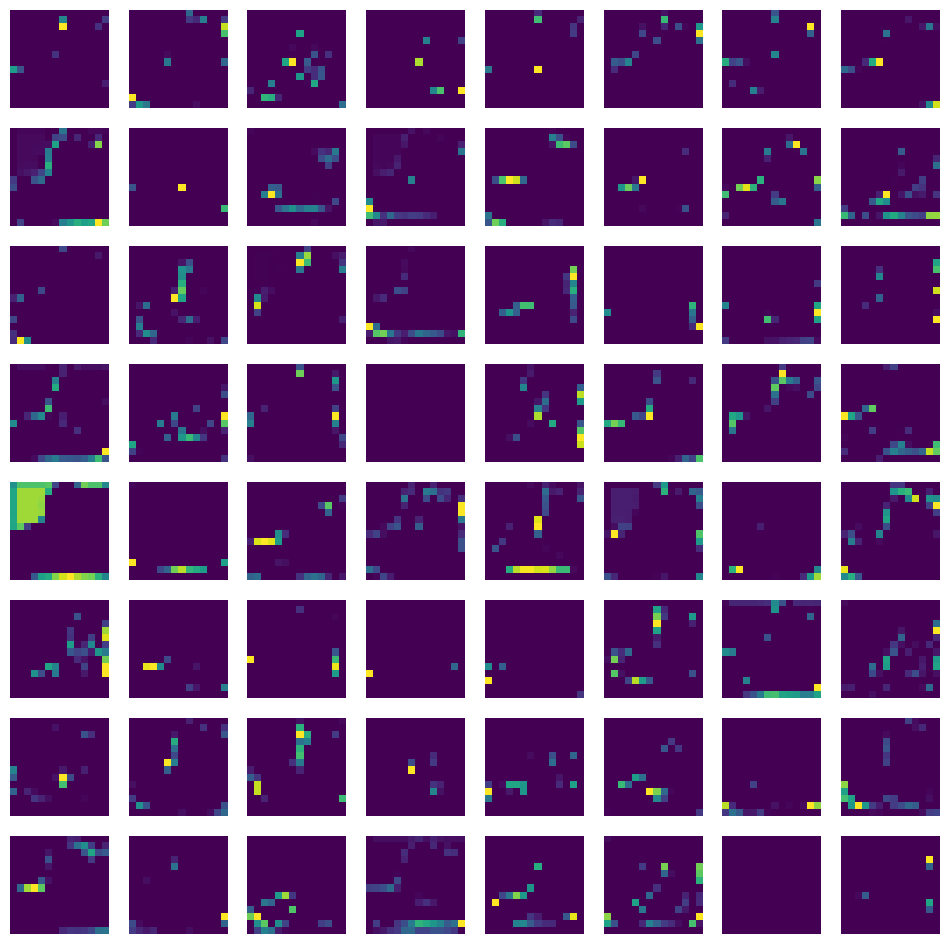

In [30]:
fig, axs = plt.subplots(8, 8, figsize=(12,12))

for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')

plt.show()

첫번째 필터가 앞서 출력한 32개의 특성맵과 곱해져 두번째 합성곱 층의 첫번째 특성맵이 됨. 시각적으로 알아보기 어려움 (추상적인 정보를 학습)